## Exercise 2

In this exercise, we will predict the two income classes in the adult dataset (The file "adult.csv" is also on Moodle). 

Answer the following questions:
1. Clean the `income` variable such that it has only two values
2. Select as set of minimum two feature variables you want to use to predict `income`. Do the necessary transformation of these variables.
3. Create X and y dataset and split the datasets into training and testing sets
4. Train a KNN classifier to predict the variable `income` based on the feature variables selected in 2 - try out some different Ks 
5. Train a logistic regression classifier to predict the variable `income` based on the feature variables selected in 2 and compare it to the KNN classifier.
6. Train a decision tree classifier to predict the variable `income` based on the feature variables selected in 2 and compare it to the previous classifiers.
7. Train a random forest classifier to predict the variable `income` based on the feature variables selected in 2 and compare it to the previous classifiers.
8. Train a AdaBoost classifier to predict the variable `income` based on the feature variables selected in 2 and compare it to the previous classifiers.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from tqdm import tqdm  # Add this import


# Set random seed for reproducibility
np.random.seed(42)

## Feature Engineering and Preprocessing
We process both numerical and categorical features:
- **Numerical Features**: Age, education-num, hours-per-week, capital-gain, and capital-loss are scaled using StandardScaler
- **Categorical Features**: Workclass, education, marital-status, occupation, relationship, and sex are one-hot encoded
- Missing values (marked as "?") are handled by replacing them with the mode for categorical variables

In [2]:
# Load the dataset
adult_data = pd.read_csv('adult.csv')

# Check unique values in income column
print("Unique values in income column before cleaning:")
print(adult_data['income'].unique())

# Clean the income variable - handle both possible formats with and without leading space
adult_data['income'] = adult_data['income'].replace({
    ' <=50K': 0, 
    ' >50K': 1,
    '<=50K': 0, 
    '>50K': 1,
    ' <=50K.': 0, 
    ' >50K.': 1,
    '<=50K.': 0, 
    '>50K.': 1
})

# Verify the cleaning worked
print("\nUnique values in income column after cleaning:")
print(adult_data['income'].unique())
print("\nValue counts in income column:")
print(adult_data['income'].value_counts())

Unique values in income column before cleaning:
['<=50K' '>50K' '<=50K.' '>50K.']

Unique values in income column after cleaning:
[0 1]

Value counts in income column:
income
0    37155
1    11687
Name: count, dtype: int64


C:\Users\victo\AppData\Local\Temp\ipykernel_14552\2394445411.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  adult_data['income'] = adult_data['income'].replace({


In [3]:
# Handle missing values
adult_data = adult_data.replace('?', np.nan)

# Select features
categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'sex']
numerical_features = ['age', 'education-num', 'hours-per-week', 'capital-gain', 'capital-loss']

# Handle missing values in categorical features
for col in categorical_features:
    adult_data[col].fillna(adult_data[col].mode()[0], inplace=True)

# Process numerical features
X_numerical = adult_data[numerical_features]
scaler = StandardScaler()
X_numerical_scaled = pd.DataFrame(
    scaler.fit_transform(X_numerical),
    columns=numerical_features
)

# Process categorical features
X_categorical = pd.get_dummies(adult_data[categorical_features])

# Combine all features
X = pd.concat([X_numerical_scaled, X_categorical], axis=1)
y = adult_data['income']

C:\Users\victo\AppData\Local\Temp\ipykernel_14552\1840630701.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  adult_data[col].fillna(adult_data[col].mode()[0], inplace=True)


## 3. Train-Test Split
Split the data into training and testing sets.

In [4]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Model Implementation and Evaluation
We'll implement several classification models and compare their performance. For each model, we'll evaluate using:
- Classification reports (precision, recall, f1-score)
- Cross-validation scores
- Additional visualizations where appropriate

#### 3.1 K-Nearest Neighbors (KNN)
- Implements k-nearest neighbors algorithm
- Uses cross-validation to find optimal K value
- Tests K values from 2 to 25
- Visualizes K-value performance

Evaluating KNN: 100%|██████████| 24/24 [04:49<00:00, 12.06s/it]


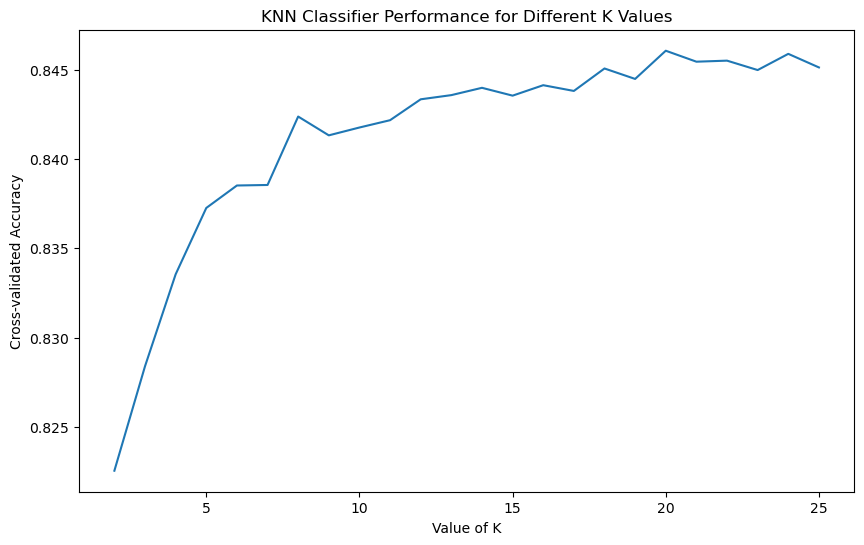


Best K value: 20

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90     11109
           1       0.73      0.57      0.64      3544

    accuracy                           0.84     14653
   macro avg       0.80      0.75      0.77     14653
weighted avg       0.84      0.84      0.84     14653



In [5]:
# Function to evaluate KNN for different K values
def evaluate_knn(k_range):
    k_scores = []
    for k in tqdm(k_range, desc="Evaluating KNN"):  # Add progress bar
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
        k_scores.append(scores.mean())
    return k_scores

# 20 is best
# Test different K values
k_range = range(2, 26)
k_scores = evaluate_knn(k_range)


# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_range, k_scores)
plt.xlabel('Value of K')
plt.ylabel('Cross-validated Accuracy')
plt.title('KNN Classifier Performance for Different K Values')
plt.show()

# Train KNN with best K
best_k = k_range[np.argmax(k_scores)]
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train, y_train)
knn_pred = knn_best.predict(X_test)

print(f"\nBest K value: {best_k}")
print("\nKNN Classification Report:")
print(classification_report(y_test, knn_pred))

#### 3.2 Logistic Regression
- Implements binary logistic regression
- Includes ROC curve visualization
- Shows classification metrics

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.94      0.90     11109
           1       0.74      0.58      0.65      3544

    accuracy                           0.85     14653
   macro avg       0.81      0.76      0.78     14653
weighted avg       0.84      0.85      0.84     14653



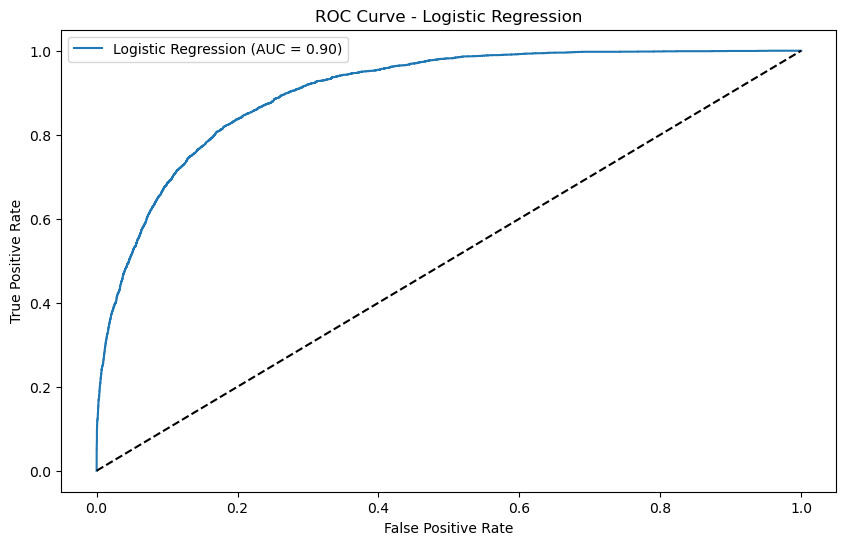

In [6]:
# Train logistic regression model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

print("Logistic Regression Classification Report:")
print(classification_report(y_test, lr_pred))

# ROC curve for logistic regression
lr_probs = lr_model.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_probs)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(10, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.show()

#### 3.3 Decision Tree
- Implements decision tree classifier
- Uses default hyperparameters
- Provides classification report

In [7]:
# Train decision tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)

print("Decision Tree Classification Report:")
print(classification_report(y_test, dt_pred))

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.89     11109
           1       0.65      0.61      0.63      3544

    accuracy                           0.82     14653
   macro avg       0.76      0.75      0.76     14653
weighted avg       0.82      0.82      0.82     14653



#### 3.4 Random Forest
- Implements random forest with 100 trees
- Shows feature importance visualization
- Demonstrates ensemble learning benefits

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.91      0.90     11109
           1       0.69      0.62      0.65      3544

    accuracy                           0.84     14653
   macro avg       0.79      0.77      0.78     14653
weighted avg       0.84      0.84      0.84     14653



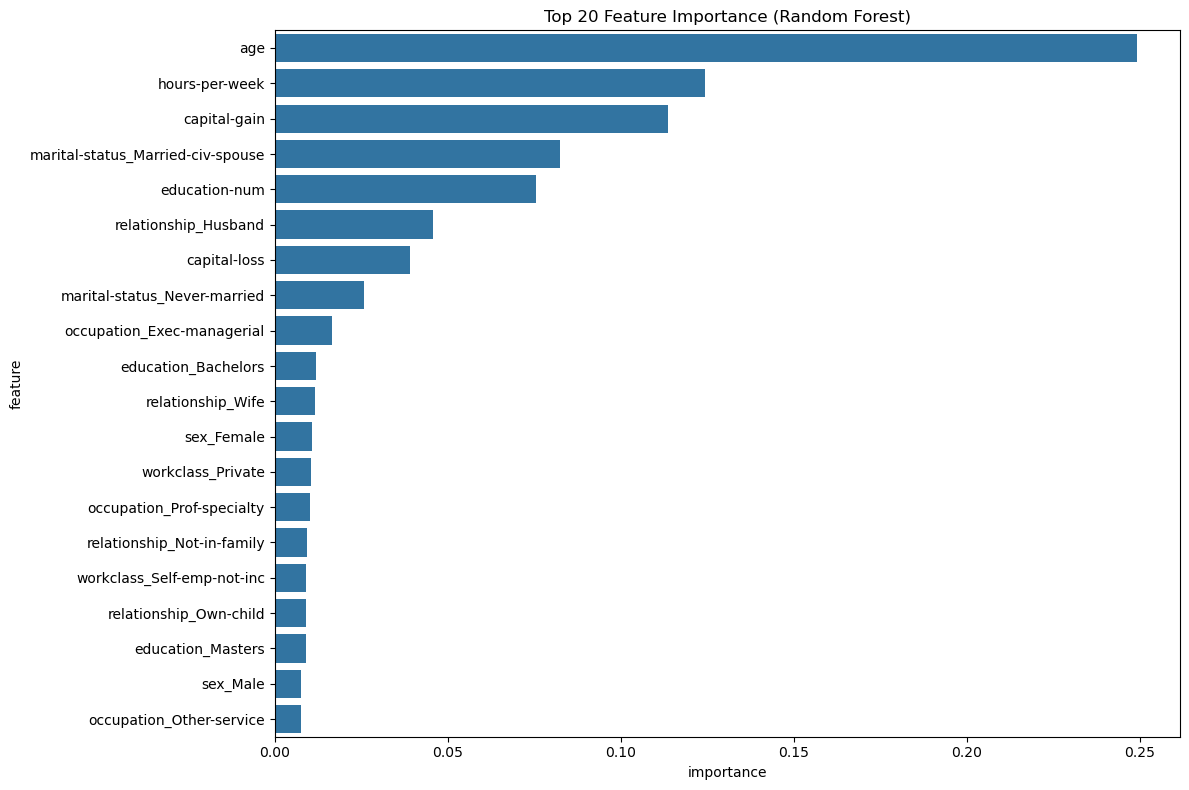

In [8]:
# Train random forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

print("Random Forest Classification Report:")
print(classification_report(y_test, rf_pred))

# Feature importance plot
plt.figure(figsize=(12, 8))
importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
})
sns.barplot(x='importance', y='feature', 
            data=importance.sort_values('importance', ascending=False).head(20))
plt.title('Top 20 Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()

#### 3.5 AdaBoost
- Implements adaptive boosting
- Uses 100 estimators
- Shows boosting performance

In [9]:
# Train AdaBoost model
ada_model = AdaBoostClassifier(n_estimators=100, random_state=42)
ada_model.fit(X_train, y_train)
ada_pred = ada_model.predict(X_test)

print("AdaBoost Classification Report:")
print(classification_report(y_test, ada_pred))

AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.94      0.91     11109
           1       0.76      0.57      0.65      3544

    accuracy                           0.85     14653
   macro avg       0.82      0.76      0.78     14653
weighted avg       0.85      0.85      0.85     14653



### 4. Model Comparison and Results

We compare all implemented models using:
- Cross-validation scores
- Classification reports
- Visual performance comparison


KNN Cross-Validation Scores:
Mean accuracy: 0.847 (+/- 0.004)

Logistic Regression Cross-Validation Scores:
Mean accuracy: 0.850 (+/- 0.004)

Decision Tree Cross-Validation Scores:
Mean accuracy: 0.823 (+/- 0.005)

Random Forest Cross-Validation Scores:
Mean accuracy: 0.845 (+/- 0.009)

AdaBoost Cross-Validation Scores:
Mean accuracy: 0.856 (+/- 0.005)

Model Comparison:
                 Model  CV Accuracy
0                  KNN     0.847078
1  Logistic Regression     0.850477
2        Decision Tree     0.823185
3        Random Forest     0.844990
4             AdaBoost     0.856026


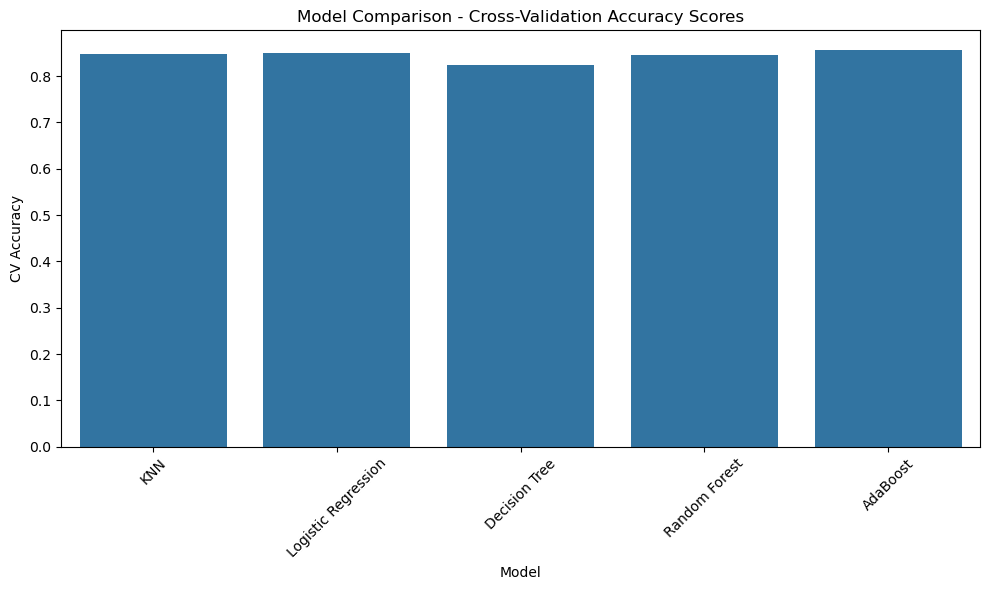

In [10]:
# Function to evaluate models with cross-validation
def evaluate_model(model, X, y, model_name):
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    print(f"\n{model_name} Cross-Validation Scores:")
    print(f"Mean accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    return cv_scores.mean()

# Evaluate all models with cross-validation
models = {
    'KNN': knn_best,
    'Logistic Regression': lr_model,
    'Decision Tree': dt_model,
    'Random Forest': rf_model,
    'AdaBoost': ada_model
}

# Calculate accuracy for each model
cv_results = []
for name, model in models.items():
    cv_mean = evaluate_model(model, X, y, name)  
    cv_results.append({'Model': name, 'CV Accuracy': cv_mean})

cv_results_df = pd.DataFrame(cv_results)
print("\nModel Comparison:")
print(cv_results_df)

# Plot model comparison 
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='CV Accuracy', data=cv_results_df)  
plt.xticks(rotation=45)
plt.title('Model Comparison - Cross-Validation Accuracy Scores')
plt.tight_layout()
plt.show()

## Conclusion

After implementing and comparing multiple classification models on the Adult Income dataset, we can draw several conclusions:

1. **Model Performance**:
   - All models achieved accuracy scores between 82-85%
   - AdaBoost performed slightly better than other models
   - The relatively close performance suggests that the problem might have reached its predictive ceiling with the current features

2. **Feature Importance**:
   - The Random Forest feature importance plot reveals that both numerical and categorical features contribute to the predictions
   - Key predictive features include capital-gain, education-num, and age
   - Relationship status and marital status also play significant roles

3. **Model Selection**:
   - For this specific problem, AdaBoost might be the preferred choice due to its slightly higher accuracy
   - However, if interpretability is important, Logistic Regression or Decision Trees might be better options

4. **Future Improvements**:
   - Feature engineering could potentially improve results
   - Hyperparameter tuning might yield better performance
   - Collecting additional relevant features might help break through the current performance ceiling

Overall, the models demonstrate good predictive capability for income classification, with room for potential improvements through more advanced techniques.